In [147]:
import sys, os, random

# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from Utils import utils

import yfinance as yf, datetime as dt
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

import ta, warnings, pdb
warnings.filterwarnings('ignore')

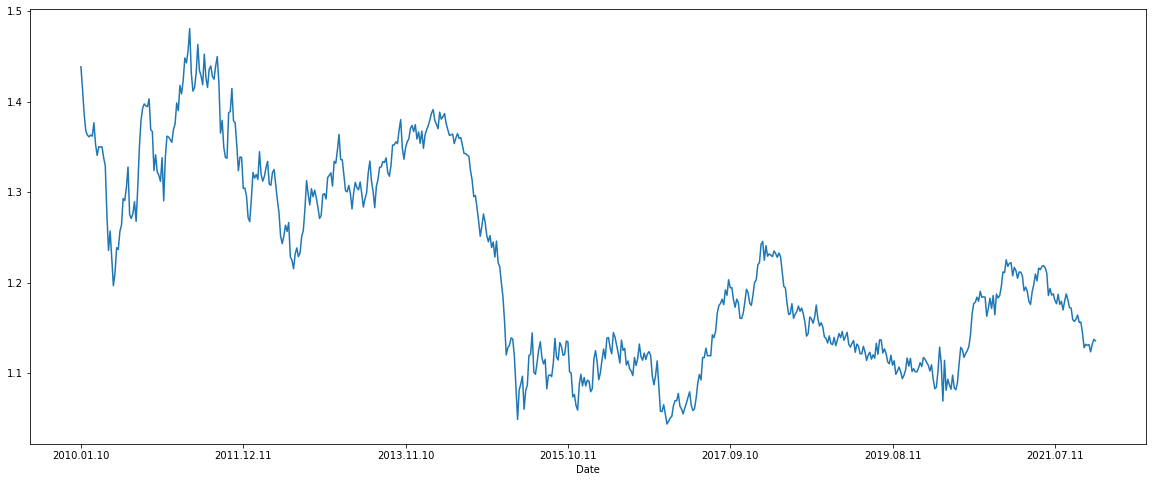

,Open,High,Low,Close,Volume,Median
Date,,,,,,
2010.01.10,1.44125,1.45785,1.43365,1.43857,229724,1.445750
2010.01.17,1.43480,1.44131,1.40285,1.41363,250323,1.422080
2010.01.24,1.41523,1.41938,1.38610,1.38611,252553,1.402740
2010.01.31,1.38627,1.40255,1.35854,1.36776,237535,1.380545
2010.02.07,1.36561,1.38380,1.35311,1.36309,249618,1.368455


In [28]:
folder, ticker, period, startdatetime, enddatetime = 'CSVData', 'EURUSD', 'Weekly', '201001100000', '202201020000'
#folder, ticker, period, startdatetime, enddatetime = 'CSVData', 'EURUSD', 'Daily', '201701020000', '202207120000'
multiplier = 100 if 'JPY' in ticker else 10000
ohlcv = pd.read_csv('../'+folder+'/'+ticker+'_'+period+'_'+startdatetime+'_'+enddatetime+'.csv', delimiter='\t')
ohlcv = utils.prep_metatrader_data(ohlcv)
plt.figure(figsize=(20,8))
ohlcv['Close'].plot()
plt.show()
ohlcv.head(5)

In [29]:
label = 'Close'
n, test_size = 8, .2
X = utils.timeseries_df(ohlcv, label, n)
y = ohlcv[[label]].iloc[n:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
print (f'Train set = {len(X_train)} samples, test set = {len(X_test)} samples')

Train set = 494 samples, test set = 124 samples


In [30]:
regr = MLPRegressor(hidden_layer_sizes=[500, 200], max_iter=1000, n_iter_no_change=500, verbose=False)
regr = XGBRegressor(n_estimators=300, max_depth=6)
regr = LinearRegression()

regr.fit(X_train, y_train.to_numpy().ravel())
predicted = regr.predict(X_test)

diff = predicted - y_test[label]
diff_df = pd.DataFrame({'Actual': y_test[label], 
                        'Predicted': predicted,
                        'Difference': diff})

mae = mean_absolute_error(predicted, y_test)
ohlcv_test = ohlcv[ohlcv.index.isin(X_test.index)]
ach = sum(abs(ohlcv_test['High']-ohlcv_test['Low']))/len(diff)
print('Mean absolute error: ' + str(round(mae*multiplier,2)) + ' pips')
print('Average candle range: ' + str(round(ach*multiplier,2)) + ' pips')

Mean absolute error: 90.29 pips
Average candle range: 162.44 pips


In [31]:
y_pred = pd.DataFrame(index = ohlcv_test.index)
y_pred['y_pred'] = predicted
y_pred['low'], y_pred['high'] = ohlcv_test['Low'], ohlcv_test['High']
y_pred['open'], y_pred['close'] = ohlcv_test['Open'], ohlcv_test['Close'] 
y_pred.head(5)

,y_pred,low,high,open,close
Date,,,,,
2019.08.25,1.114729,1.09630,1.11639,1.11496,1.09893
2019.09.01,1.101540,1.09257,1.10846,1.09899,1.10245
2019.09.08,1.101029,1.09267,1.11094,1.10256,1.10697
2019.09.15,1.109624,1.09902,1.10863,1.10720,1.10187
2019.09.22,1.100553,1.09038,1.10253,1.10120,1.09411


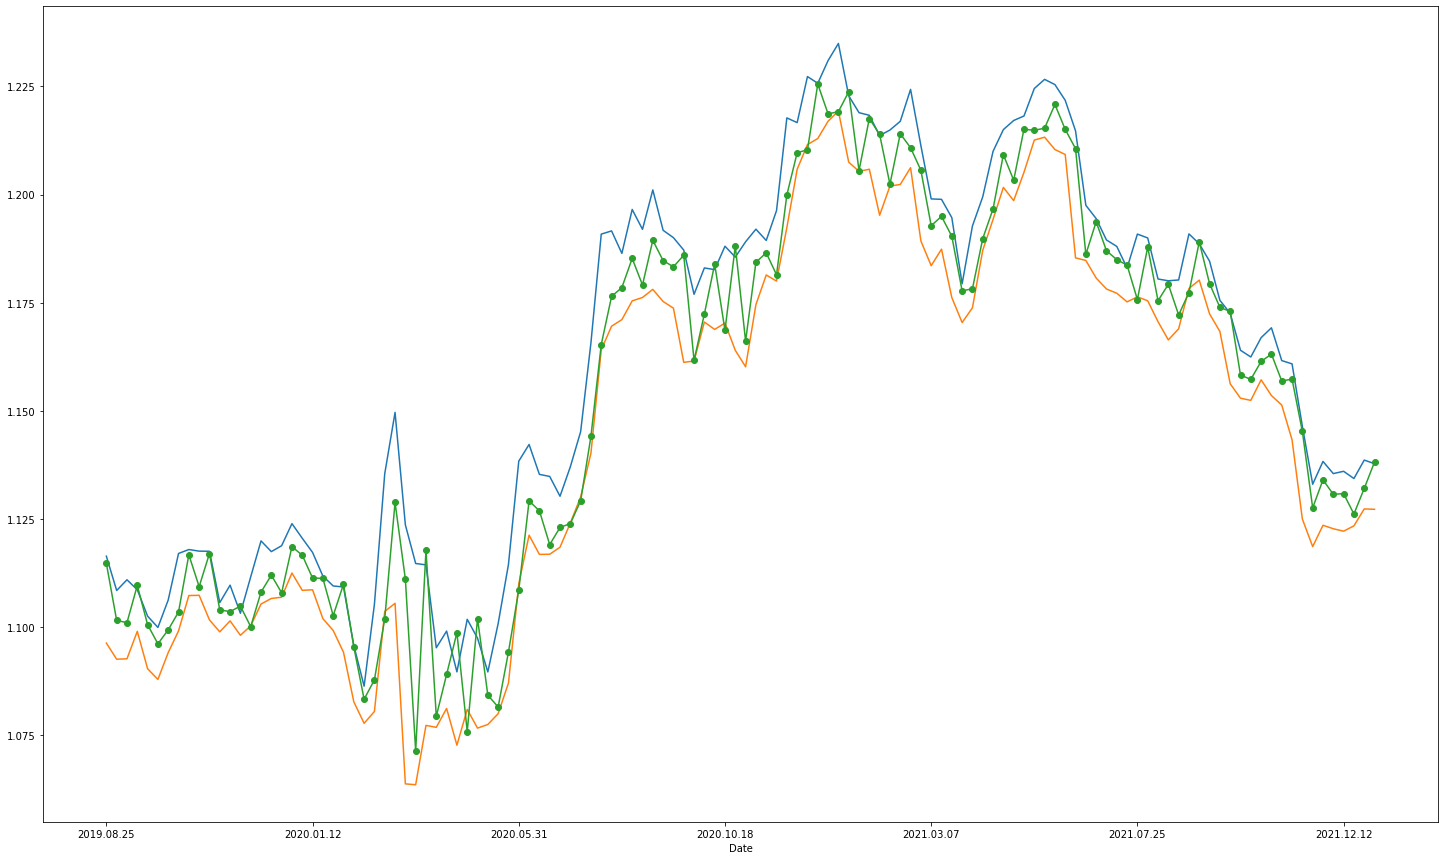

Hitrate: 79.84%
Number of candles: 124


In [32]:
y_pred, hitrate = utils.get_hitrate(y_pred)
plt.figure(figsize=(25,15))
y_pred['high'].plot()
y_pred['low'].plot()
y_pred['y_pred'].plot(marker = 'o')
plt.show()
print('Hitrate: ' + str(round(hitrate*100,2)) + '%')
print('Number of candles: ' + str(len(y_pred)))

In [33]:
y_pred, direction = utils.get_direction(y_pred)
y_pred, OR = utils.get_OR(y_pred)
y_pred, pips = utils.get_pips(y_pred, multiplier)
print('Direction: ' + str(round(direction*100,2)) + '%')
print('OR: ' + str(round(OR*100,2)) + '%')
print('Total pips: ' + str(round(pips,2)))
print('Total pips if no losing positions: ' + str(sum(y_pred[y_pred['pips']>=0]['pips'])))

Direction: 49.19%
OR: 81.45%
Total pips: -1104.56
Total pips if no losing positions: 1581.53779123775


In [146]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000